In [6]:
import numpy as np
from numba import jit, prange
import time
import matplotlib.pyplot as plt
import math
plt.rc('font', family='Helvetica')

B-Field equation which has been calculated and copied from Sympy. Not ideal right now, but it's fast.
 Previous version took ~200us. Current Version takes ~500ns.

In [7]:
@jit(nopython = True, inline = 'always', fastmath = True)
def BFieldExpansionFourTerm(x, y, z, Bmag = 0.5):
    #Bx = x*z*(x**2 + y**2)*(-4.8e-5*z**2/(z**2 + 1.0e-6) + 2.4e-5)/(16*(z**2 + 1.0e-6)**3) + 1.0e-6*x*z/(z**2 + 1.0e-6)**2
    #By = y*z*(x**2 + y**2)*(-4.8e-5*z**2/(z**2 + 1.0e-6) + 2.4e-5)/(16*(z**2 + 1.0e-6)**3) + 1.0e-6*y*z/(z**2 + 1.0e-6)**2
    #Bz = (x**2 + y**2)**2*(0.000384*z**4/(z**2 + 1.0e-6)**2 - 0.000288*z**2/(z**2 + 1.0e-6) + 2.4e-5)/(64*(z**2 + 1.0e-6)**3) + 1/(1000000.0*z**2 + 1)

    Bx = x*z*(x**2 + y**2)**3*(-0.64512*z**6/(z**2 + 1.0e-6)**3 + 0.96768*z**4/(z**2 + 1.0e-6)**2 - 0.4032*z**2/(z**2 + 1.0e-6) + 0.04032)/(18432*(z**2 + 1.0e-6)**5) - x*z*(x**2 + y**2)**2*(-0.00384*z**4 /
                                                                                                                                                                                              (z**2 + 1.0e-6)**2 + 0.00384*z**2/(z**2 + 1.0e-6) - 0.00072)/(384*(z**2 + 1.0e-6)**4) + x*z*(x**2 + y**2)*(-4.8e-5*z**2/(z**2 + 1.0e-6) + 2.4e-5)/(16*(z**2 + 1.0e-6)**3) + 1.0e-6*x*z/(z**2 + 1.0e-6)**2
    By = y*z*(x**2 + y**2)**3*(-0.64512*z**6/(z**2 + 1.0e-6)**3 + 0.96768*z**4/(z**2 + 1.0e-6)**2 - 0.4032*z**2/(z**2 + 1.0e-6) + 0.04032)/(18432*(z**2 + 1.0e-6)**5) - y*z*(x**2 + y**2)**2*(-0.00384*z**4 /
                                                                                                                                                                                              (z**2 + 1.0e-6)**2 + 0.00384*z**2/(z**2 + 1.0e-6) - 0.00072)/(384*(z**2 + 1.0e-6)**4) + y*z*(x**2 + y**2)*(-4.8e-5*z**2/(z**2 + 1.0e-6) + 2.4e-5)/(16*(z**2 + 1.0e-6)**3) + 1.0e-6*y*z/(z**2 + 1.0e-6)**2
    Bz = (-x**2/4 - y**2/4)*(8.0e-6*z**2/(z**2 + 1.0e-6) - 2.0e-6)/(z**2 + 1.0e-6)**2 - (x**2 + y**2)**3*(0.04608*z**6/(z**2 + 1.0e-6)**3 - 0.0576*z**4/(z**2 + 1.0e-6)**2 + 0.01728*z**2/(z**2 +
                                                                                                                                                                                           1.0e-6) - 0.00072)/(2304*(z**2 + 1.0e-6)**4) + (x**2 + y**2)**2*(0.000384*z**4/(z**2 + 1.0e-6)**2 - 0.000288*z**2/(z**2 + 1.0e-6) + 2.4e-5)/(64*(z**2 + 1.0e-6)**3) + 1/(1000000.0*z**2 + 1)
    return Bmag*Bx, Bmag*By, Bmag*Bz


Paralellised particle tracing function, which uses the Euler-Cromer method to intergrate the equations of motion of an electron in 
a magnetic field.


In [8]:
@jit(nopython = True, fastmath=True, parallel = True)
def euler_dz_simultaneous_rays(r, v, z, alpha, dz, n, B):
    
    num_rays = r.shape[1]
    
    n_threads = 16 #Number of threads on 8 core cpu
    thread_block_size = int(num_rays/n_threads) #Number of rays per thread
    macro_block_size = 64 #Size of blocks that are fed to a thread at any one time
    macro_blocks = int(thread_block_size/macro_block_size) #Number of macroblocks in each thread
    
    #Initialise paralellisation of code execution
    for thread in prange(n_threads):
        
        #get starting index for the block of rays going to each thread.
        thread_idx = thread*thread_block_size
        
        for macro_block in range(macro_blocks):

            #get starting index for the block of rays of each macroblock in a thread.
            macro_block_idx = macro_block*macro_block_size
            
            #combine the starting index of the thread and macroblock
            idx_start = thread_idx + macro_block_idx
            
            #Reset the step counter (it's only a float so no assignment by reference issues)
            z0 = z
            
            #Step each ray through it's number of steps
            for i in range(1, n):
                
                #step through each macroblock
                for j in range(macro_block_size):
                    
                    #get b field and velocity term (See Szilagyi Chapter 2)
                    Bx, By, Bz = B(r[i-1, idx_start+j, 0], r[i-1, idx_start+j, 1], z0)
                    v_ = math.sqrt(v[i-1, idx_start+j, 0]**2+v[i-1, idx_start+j, 1]**2+1)

                    #Increment velocity.
                    v[i, idx_start+j, 0] = v[i-1, idx_start+j, 0] + v_*alpha*(-(1+v[i-1, idx_start+j, 0]**2)*By+v[i-1, idx_start+j, 1]*(v[i-1, idx_start+j, 0]*Bx+Bz))*dz
                    v[i, idx_start+j, 1] = v[i-1, idx_start+j, 1] + v_*alpha*(+(1+v[i-1, idx_start+j, 1]**2)*Bx-v[i-1, idx_start+j, 0]*(v[i-1, idx_start+j, 1]*By+Bz))*dz    
                    
                    #Obtain new position       
                    r[i, idx_start+j, 0]  = r[i-1, idx_start+j, 0]  + v[i, idx_start+j, 0]*dz
                    r[i, idx_start+j, 1]  = r[i-1, idx_start+j, 1]  + v[i, idx_start+j, 1]*dz   
                    
                #Find next z for Bfield
                z0 = z0 + dz
        
    return r, v

Run the script to trace multiple rays. Time it and plot it. 

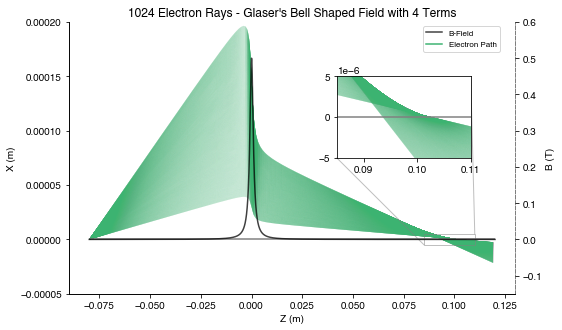

In [9]:
#Define constants
q  = -1.60217662e-19
m = 9.10938356e-31
c = 2.99792458e8

#Choose initial angle of particle in polar and alpha directions (radians)
polar_angle = 0
alpha_angle = 0

#Get relativistic acceleration velocity for a 300kV electron
v_acc = 1*c*(1-(1-(q*3e5)/(m*(c**2)))**(-2))**(1/2)
gamma = 1/(1-(v_acc**2/c**2))**(1/2)

#Define number of rays to calculate in parelell
num_rays = 2**10

#Distance to run simulation in metres
l_max = 20e-2
z_init = -8e-2

#Step size of particle integrator
dz = 1e-5

#Integer steps to run the integration scheme for and number of rays
steps = int(l_max/dz)

#Make a 2 x steps x number of rays size array to store the particle locations at each step
r = np.zeros((steps, num_rays, 2), dtype = np.float64)

#Create an array of initial particle locations from 0 to 100 micrometres away from the centre in the x direction
x_init = np.linspace(0, 0, num_rays, dtype = np.float64)
y_init = np.linspace(0, 0, num_rays, dtype = np.float64)

#Update the initial conditions for the particle location
r[0, :, 0] = x_init
r[0, :, 1] = y_init

#We need to make a 2 x steps x number of rays size array to store the particle velocities at each step
v = np.zeros((steps, num_rays, 2), dtype = np.float64)

polar_init = np.linspace(1e-3, 5e-3, num_rays, dtype = np.float64)
alpha_init = np.linspace(1, 1, num_rays, dtype = np.float64)
vx_init = np.sin(polar_init) * np.cos(alpha_init)
vy_init = np.sin(polar_init) * np.sin(alpha_init)
v[0, :, 0] = vx_init
v[0, :, 1] = vy_init

#initialise function in numba
r_test = np.zeros((steps, num_rays, 2), dtype = np.float64)
v_test = np.zeros((steps, num_rays, 2), dtype = np.float64)
z_test = np.array(np.ones((num_rays))*z_init) 

alpha = np.float64(q/(gamma*m*v_acc))

pts, _ = euler_dz_simultaneous_rays(r_test, v_test, z_init, alpha, dz, 1, BFieldExpansionFourTerm)

#Run paralellised function
z = np.array(np.ones((num_rays))*z_init) 
pts, _ = euler_dz_simultaneous_rays(r.copy(), v.copy(), z_init, alpha, dz, steps, BFieldExpansionFourTerm)

#Plot Rays
fig, ax = plt.subplots(figsize = (8, 5))
z_coords = np.ones((num_rays, steps))*np.linspace(z_init, z_init+steps*dz-dz, steps)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.plot(z_coords.T[::100], pts[::100, :, 0], 'mediumseagreen', linewidth = .05)
ax.set_title("1024 Electron Rays - Glaser's Bell Shaped Field with 4 Terms")
ax.set_xlabel('Z (m)')
ax.set_ylabel('X (m)')
ax.set_ylim([-0.00005, 0.00020])
ax.hlines(0, z_init, z_init+l_max, 'gray')
ax.plot([],[], c = 'k', alpha = 0.75, label = 'B-Field')
ax.plot([],[], c='mediumseagreen', label='Electron Path')
fig.legend(fontsize = '8', bbox_to_anchor=(0.88, 0.88))

axin = ax.inset_axes([0.6, 0.5, 0.3, 0.3])
axin.plot(z_coords.T[::100], pts[::100, :, 0], 'mediumseagreen', linewidth = 0.05)
axin.set_xlim(0.085, 0.11)
axin.set_ylim(-0.000005, +0.000005)
axin.hlines(0, z_init, z_init+l_max, 'gray')
axin.plot(np.linspace(z_init, z_init+steps*dz-dz, steps), BFieldExpansionFourTerm(0, 0, np.linspace(z_init, z_init+steps*dz-dz, steps))[2], color = 'k', alpha = 0.75, label = 'B-Field')

ax.indicate_inset_zoom(axin)
ax2 = ax.twinx()
ax2.spines.top.set_visible(False)

ax2.set_ylim([-0.15, 0.6])
ax2.plot(np.linspace(z_init, z_init+steps*dz-dz, steps), BFieldExpansionFourTerm(0, 0, np.linspace(z_init, z_init+steps*dz-dz, steps))[2], color = 'k', alpha = 0.75, label = 'B-Field')
ax2.set_ylabel('B (T)')

for axis in ['right']:
    ax2.spines[axis].set_linewidth(1)
    ax2.spines[axis].set_linestyle('--')
    ax2.spines[axis].set_alpha(0.5)

fig.savefig('Paralell_Rays.svg', dpi = 800)
fig.savefig('Paralell_Rays.pdf', dpi = 800)

In [10]:
%timeit pts, _ = euler_dz_simultaneous_rays(r, v, z_init, alpha, dz, steps, BFieldExpansionFourTerm)
print('Number of steps for each ray = ', steps)
print('Number of rays = ', num_rays)

86.9 ms ± 6.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Number of steps for each ray =  20000
Number of rays =  1024
